定义二维平面的小车位姿在世界坐标系下表示为：$P_r = [x, y, \theta]$，速度为$[v, w]$，其中$v$表示线速度、$w$表示角速度。

里程计(continuous):
$$\begin{align}
\begin{bmatrix} {\dot x} \\ {\dot y} \\ {\dot \theta} \\ {\dot v} \\ {\dot w}\end{bmatrix} =
\begin{bmatrix} {cos\theta} &{0} \\ {sin\theta} &{0} \\ {0} &{1} \\ {0} & {0} \\ {0} & {0}\end{bmatrix} \cdot
\begin{bmatrix} {v} \\ {w}\end{bmatrix}
\tag{1}\end{align}$$

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [51]:

class DifferentialDrive(object):
    """Differential Drive Chassis Definition

    Args:
        init_state: [x, y, theta, v, w] unit: mm, rad
    """
    def __init__(self, init_state=[0., 0., 0., 0., 0.]):
        self._x, self._y, self._th, self._v, self._w = init_state
    
    def f_state(self, X=[0., 0., 0., 0., 0.], t=0.):
        x, y, th, v, w = X
        return [v * np.cos(th), v * np.sin(th), w, 0., 0.]

# 差速底盘
x0 = [0., 0., 0., 500., np.deg2rad(30.)]
chassis = DifferentialDrive(init_state=X0)

t_end = 1000.
tspan = np.arange(0, t_end, 0.1)
sol = odeint(chassis.f_state, x0, tspan)

x_s, y_s, th_s, v_s, w_s = sol[:,0], sol[:,1], sol[:,2], sol[:,3], sol[:,4]

if False:
    fig,ax = plt.subplots()
    ax.grid()
    ax.plot(x_s, y_s)

    fig,ax = plt.subplots(3, 1)
    ax[0].grid()
    ax[0].plot(x_s)
    ax[1].grid()
    ax[1].plot(y_s)
    ax[2].grid()
    ax[2].plot(np.rad2deg(th_s))

离散里程计，设采样时间为$T_s$，在$k$时刻，小车位姿为$\begin{bmatrix}x_k, y_k, \theta_k\end{bmatrix}$，速度为$\begin{bmatrix} v_k, w_k\end{bmatrix}$

则：
$$\begin{align}
\begin{bmatrix} {\nabla x_k} \\ {\nabla y_k} \\ {\nabla \theta_k} \end{bmatrix} = 
\begin{bmatrix} {cos\theta_k} &{0} \\ {sin\theta_k} &{0} \\ {0} &{1} \end{bmatrix} \cdot
\begin{bmatrix} {v_k} \\ {w_k} \end{bmatrix} \cdot T_s
\tag{2}\end{align}$$

小车状态从$k$时刻，更新$k+1$时刻的状态:
$$\begin{align}
\begin{bmatrix} {x_{k+1}} \\ {y_{k+1}} \\ {\theta_{k+1}} \end{bmatrix} &=
\begin{bmatrix} {x_{k}} \\ {y_{k}} \\ {\theta_{k}} \end{bmatrix} +
\begin{bmatrix} {\nabla x_k} \\ {\nabla y_k} \\ {\nabla \theta_k} \end{bmatrix} \nonumber \\ &=
\begin{bmatrix} {x_{k}} \\ {y_{k}} \\ {\theta_{k}} \end{bmatrix} + 
\begin{bmatrix} {cos\theta_k} &{0} \\ {sin\theta_k} &{0} \\ {0} &{1} \end{bmatrix} \cdot
\begin{bmatrix} {v_k} \\ {w_k} \end{bmatrix} \cdot T_s \nonumber \\ &= 
\begin{bmatrix} {x_{k}} \\ {y_{k}} \\ {\theta_{k}} \end{bmatrix} + 
\begin{bmatrix} {v_k cos\theta_k \cdot T_s} \\ {v_k sin\theta_k \cdot Ts} \\ {w_k \cdot T_s} \end{bmatrix} \nonumber \\ &=
\begin{bmatrix} {x_k + v_k cos\theta_k \cdot T_s} \\ {y_k + v_k sin\theta_k \cdot Ts} \\ {\theta_k + w_k \cdot T_s}\end{bmatrix}
\tag{3}\end{align}$$

进一步地，考虑小车速度的更新：
$$\begin{align}
\begin{bmatrix} {x_{k+1}} \\ {y_{k+1}} \\ {\theta_{k+1}} \\ {v_{k+1}} \\ {w_{k+1}}\end{bmatrix} &=
\begin{bmatrix} {x_k + v_k cos\theta_k \cdot T_s} \\ {y_k + v_k sin\theta_k \cdot Ts} \\ {\theta_k + w_k \cdot T_s} \\ {v_k} \\ {w_k}\end{bmatrix} + 
\begin{bmatrix} {0} \\ {0} \\ {0} \\ {\nabla v_k} \\ {\nabla w_k} \end{bmatrix}
\tag{4}\end{align}$$

令$u_k = \begin{bmatrix} {0} & {0} & {0} & {\nabla v_k} & {\nabla w_k}\end{bmatrix}^{\mathsf{T}}$，式(4)可化为：
$$\begin{align}
\begin{bmatrix} {x_{k+1}} \\ {y_{k+1}} \\ {\theta_{k+1}} \\ {v_{k+1}} \\ {w_{k+1}}\end{bmatrix} &=
\begin{bmatrix} {x_k + v_k cos\theta_k \cdot T_s} \\ {y_k + v_k sin\theta_k \cdot Ts} \\ {\theta_k + w_k \cdot T_s} \\ {v_k} \\ {w_k}\end{bmatrix} + 
u_k
\tag{4}\end{align}$$

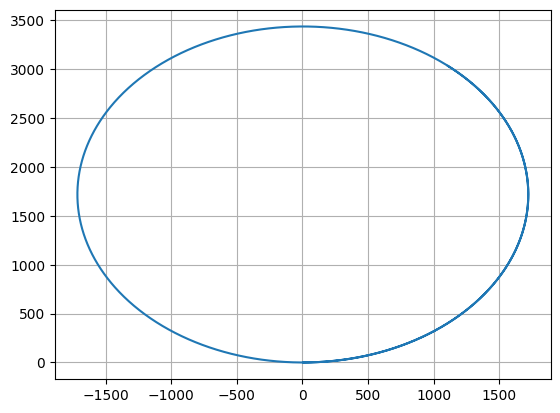

In [13]:
class DifferentialDriveDiscrete(object):
    """Differential Drive Chassis Definition, Discrete Version

    Args:
        init_state: [x, y, theta, v, w] unit: mm, rad
    """
    def __init__(self, init_state=[0., 0., 0., 0., 0.], Ts=0.02):
        self._Ts = Ts
        self._x, self._y, self._th, self._v, self._w = init_state
    
    def f_state(self, X=[0., 0., 0., 0., 0.], t=0.):
        x, y, th, v, w = X
        return [v * np.cos(th), v * np.sin(th), w, 0., 0.]
    
    def update(self, u=[0., 0.]):
        Ts = self._Ts
        x, y, th, v, w = self._x, self._y, self._th, self._v, self._w
        self._x, self._y, self._th, self._v, self._w = x + v*np.cos(th)*Ts, y + v*np.sin(th)*Ts, th + w*Ts, v+u[0], w+u[1]
    
    @property
    def state(self):
        return [self._x, self._y, self._th, self._v, self._w]

Ts = 0.02
X0 = [0., 0., 0., 300., np.deg2rad(10.)]
chassis = DifferentialDriveDiscrete(init_state=X0, Ts=Ts)

t_end = 50.
ts = 0.
x_s, y_s, th_s, v_s, w_s = [], [], [], [], []
while ts <= t_end:
    chassis.update()
    x, y, th, v, w = chassis.state
    x_s.append(x)
    y_s.append(y)
    th_s.append(th)
    v_s.append(v)
    w_s.append(w)
    ts += Ts
    
if True:
    fig,ax = plt.subplots()
    ax.grid()
    ax.plot(x_s, y_s)

In [14]:
300/np.deg2rad(10.)

1718.8733853924698